# NLP model for detecting signs of dpression from google search phrases
This notebook file is for training a model to be used in this [hackathon](https://hackon.hackerearth.com/). It will take a phrase as input and use traditional NLP and sentiment analysis methods to analyse whether the individual who used the phrase is depressed or not. 
<br>
# Datasets
We used two different datasets for this model. The problem is a classification question that has to decide whether a person is depressed (true state) or not depressed (false state). We used 2 datasets to train the true and false state.

The first [dataset](https://www.kaggle.com/nikhileswarkomati/suicide-watch) is from kaggle. It is a collection of posts from "SuicideWatch" and "depression" subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021. We took the posts that were written by people suffering from depression as the true state.

The second [dataset](https://www.kaggle.com/kazanova/sentiment140) is a sentiment analysis dataset. It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative,  2 = neutral, 4 = positive) and they can be used to detect sentiment. We took the dataset that includes nuetral and positive flags.

We did it this way because the 'negative' statements from the twitter sentiment analysis dataset might be some tweet regarding a hate crime, or an angry tweet. It does not necssarily have to be the words of a person undergoing depression. So we overcame this with the reddit dataset. Going through the sub reddits mentioned, it was clear that most of the posts were regarding depression/existential crisis. Any post swaying fom these topics would be quickly taken down by the moderators. So, this was the clearest data we would get that could inculcate the psyche of a depressed person.

Importing dependancies

In [22]:
# Google drive to store models/dataset
from google.colab import drive
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
drive.mount('/content/gdrive', force_remount=True)

#stopwords
import nltk
nltk.download('stopwords')

Mounted at /content/gdrive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Declaring datasets

In [23]:
true_df = pd.read_csv("gdrive/MyDrive/Suicide_Detection.csv")
true_df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [24]:
true_df.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [25]:
true_df['target']=1
true_df.drop('class', axis=1, inplace=True)
true_df.head()

,Unnamed: 0,text,target
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,1
2,4,Finally 2020 is almost over... So I can never ...,1
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [26]:
false_df=pd.read_csv("gdrive/MyDrive/training.1600000.processed.noemoticon.csv", encoding='latin')
false_df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [27]:
false_df=false_df[false_df["0"]>=2]
false_df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [28]:
false_df = false_df.drop(['1467810369', 'Mon Apr 06 22:19:45 PDT 2009','NO_QUERY','_TheSpecialOne_'], axis=1)
false_df.columns= ["target","text"]
false_df.reset_index(drop=True, inplace=True)
false_df['target']=0
false_df.head()

,target,text
0,0,I LOVE @Health4UandPets u guys r the best!!
1,0,im meeting up with one of my besties tonight! ...
2,0,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,0,Being sick can be really cheap when it hurts t...
4,0,@LovesBrooklyn2 he has that effect on everyone


## Prepocessing dataset

In [29]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [30]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [31]:
df = true_df.append(false_df)
df.head()

,Unnamed: 0,text,target
0,2.0,Ex Wife Threatening SuicideRecently I left my ...,1
1,3.0,Am I weird I don't get affected by compliments...,1
2,4.0,Finally 2020 is almost over... So I can never ...,1
3,8.0,i need helpjust help me im crying so hard,1
4,9.0,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [21]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 33s, sys: 598 ms, total: 1min 33s
Wall time: 1min 34s


##Dataset Visualization

In [32]:
df.agg('target')

0         1
1         1
2         1
3         1
4         1
         ..
799995    0
799996    0
799997    0
799998    0
799999    0
Name: target, Length: 1032074, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

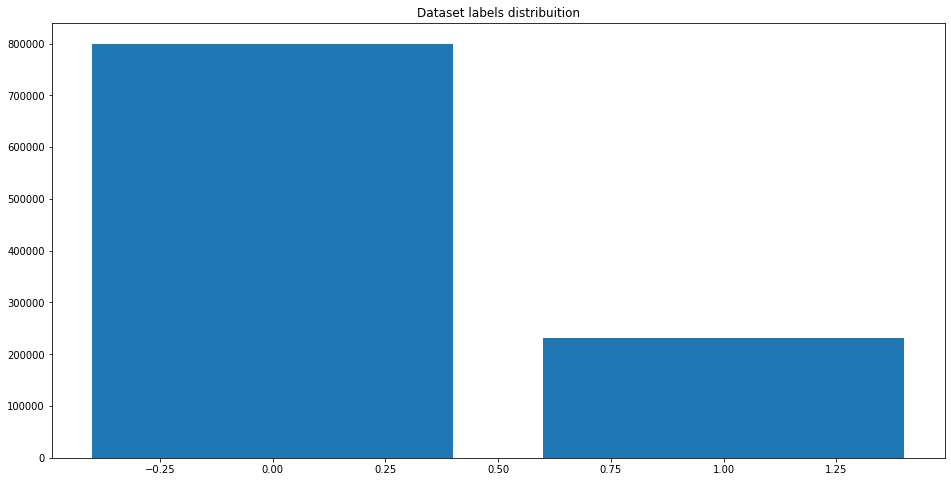

In [33]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [34]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 691489
Test size: 340585


In [35]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 6.03 s, sys: 1.89 s, total: 7.93 s
Wall time: 7.95 s


##Building a Word2Vec model

In [36]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [37]:
w2v_model.build_vocab(documents)

In [38]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save("word2vec.model")

CPU times: user 1h 11min 50s, sys: 17 s, total: 1h 12min 7s
Wall time: 36min 58s


## Building tokenizer model

In [39]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 460097
CPU times: user 30.8 s, sys: 234 ms, total: 31 s
Wall time: 31.1 s


In [40]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

## Creating train, test dataset

In [42]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 43.4 s, sys: 1.02 s, total: 44.5 s
Wall time: 44.3 s


In [43]:
labels = df_train.target.unique().tolist()
labels

[0, 1]

In [44]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (691489, 1)
y_test (340585, 1)


In [45]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (691489, 300)
y_train (691489, 1)

x_test (340585, 300)
y_test (340585, 1)


In [46]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(460097, 300)


In [47]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Defining ML model

In [48]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.0.174.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.174.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [49]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          138029100 
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 138,189,601
Trainable params: 160,501
Non-trainable params: 138,029,100
_________________________________________________________________


In [50]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Training

In [51]:
%%time
SEQUENCE_LENGTH = 300
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
608/608 [==============================] - 166s 221ms/step - loss: 0.2180 - accuracy: 0.9157 - val_loss: 0.1154 - val_accuracy: 0.9599


Epoch 2/10
608/608 [==============================] - 128s 210ms/step - loss: 0.1043 - accuracy: 0.9647 - val_loss: 0.1130 - val_accuracy: 0.9603


Epoch 3/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0951 - accuracy: 0.9680 - val_loss: 0.0969 - val_accuracy: 0.9667


Epoch 4/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0906 - accuracy: 0.9688 - val_loss: 0.0956 - val_accuracy: 0.9665


Epoch 5/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0875 - accuracy: 0.9700 - val_loss: 0.1049 - val_accuracy: 0.9644


Epoch 6/10
608/608 [==============================] - 128s 211ms/step - loss: 0.1216 - accuracy: 0.9591 - val_loss: 0.1195 - val_accuracy: 0.9594


Epoch 7/10
608/608 [==============================] - 128s 211ms/step - loss: 0.1042 - accuracy: 0.9648 - val_loss: 0.1057 - val_accuracy: 0.9628


Epoch 8/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0922 - accuracy: 0.9689 - val_loss: 0.1034 - val_accuracy: 0.9645


Epoch 9/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0878 - accuracy: 0.9703 - val_loss: 0.0903 - val_accuracy: 0.9683


Epoch 10/10
608/608 [==============================] - 128s 211ms/step - loss: 0.0844 - accuracy: 0.9713 - val_loss: 0.0997 - val_accuracy: 0.9666


CPU times: user 1min 35s, sys: 12.7 s, total: 1min 47s
Wall time: 22min 8s


## Evaluation

In [52]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

333/333 [==============================] - 21s 63ms/step - loss: 0.1012 - accuracy: 0.9657

ACCURACY: 0.9657089710235596
LOSS: 0.10124626755714417
CPU times: user 3.55 s, sys: 831 ms, total: 4.38 s
Wall time: 25.9 s


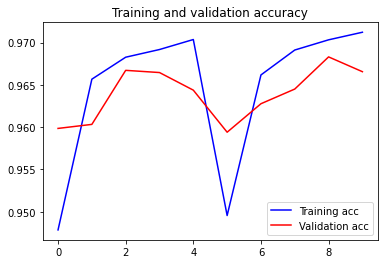

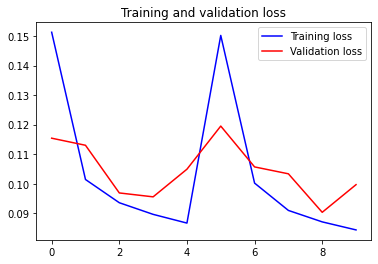

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [59]:
POSITIVE = False
NEGATIVE = True

SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score):
    label = POSITIVE      
    if score <= SENTIMENT_THRESHOLDS[0]:
        label = POSITIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
        label = NEGATIVE
    return label

## Prediction and saving models

In [60]:
def predict(text, def_model=model):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = def_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [65]:
model.save("gdrive/MyDrive/best_model.h5", overwrite=True)

In [66]:
from tensorflow.keras.models import load_model
model1 = load_model('gdrive/MyDrive/best_model.h5')

In [69]:
predict("painless way to die", model1)

{'elapsed_time': 0.1011207103729248,
 'label': True,
 'score': 0.8831092119216919}

In [70]:
predict("painless way to die")

{'elapsed_time': 0.6541709899902344,
 'label': True,
 'score': 0.8826261758804321}

In [73]:
predict("chicken curry recipe",model1)

{'elapsed_time': 0.09487771987915039,
 'label': False,
 'score': 0.0018591582775115967}

In [71]:
predict("chicken curry recipe")

{'elapsed_time': 0.4957702159881592,
 'label': False,
 'score': 0.0018694400787353516}